In [1]:
import numpy as np
import pandas as pd
import pickle
import re  
import string
from collections import Counter
import nltk 
# nltk.download('stopwords')  
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 6]

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [776]:
dk = pd.read_pickle('data/dk_exclusive.pkl')
fd = pd.read_pickle('data/fd_exclusive.pkl')

In [777]:
dk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5257 entries, 0 to 8930
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   created         5257 non-null   object
 1   text            5257 non-null   object
 2   username        5257 non-null   object
 3   location        3746 non-null   object
 4   follower count  5257 non-null   int64 
 5   friend count    5257 non-null   int64 
 6   retweet         5257 non-null   int64 
 7   source          5253 non-null   object
dtypes: int64(3), object(5)
memory usage: 369.6+ KB


# Clean the dataframe

In [778]:
def preprocess(raw_text):
    stopwords_set = set(stopwords.words('english'))
    #Remove punctuations and stopwords
    cleaned = " ".join([i for i in re.sub(r'[^\w\s]', " ", raw_text).lower().split() if i not in stopwords_set])
    #Remove prefixed 'b'
    cleaned = re.sub(r'^b\s+', "", cleaned)
    #Remove retweet 'rt'
    cleaned = re.sub(r'^rt\s+', "", cleaned)
    # Remove single characters from the start
    cleaned = re.sub(r'\^[a-zA-Z]\s+', ' ', cleaned) 
    # Remove single characters
    cleaned = re.sub(r'\s+[a-zA-Z]\s+', ' ', cleaned)
    # Remove words with '_'  
    cleaned = re.sub('\w*\_\w*', ' ', cleaned)
    #Remove URLs
    cleaned = re.sub(r'http\S+', "", cleaned) 
    # Remove words with containing numbers
    cleaned = re.sub('\w*\d\w*', '', cleaned)
    # Substituting multiple spaces with single space
    cleaned= re.sub(r'\s+', ' ', cleaned, flags=re.I)
    return cleaned

In [779]:
dk_clean = pd.DataFrame(dk.text.apply(preprocess))
fd_clean = pd.DataFrame(fd.text.apply(preprocess))
dk_clean.to_pickle("data/dk_clean.pkl")
fd_clean.to_pickle("data/fd_clean.pkl")

In [780]:
# Another Option to clean and vectorize

# dk_corpus = "".join([str(i) for i in dk['text']])
# cleaned = preprocess(dk_corpus)

# from nltk.tokenize import TweetTokenizer
# tt = TweetTokenizer()
# tokens = tt.tokenize(cleaned)

# stemmer = SnowballStemmer('english')
# stems = [stemmer.stem(token) for token in tokens]

# vectorizer = TfidfVectorizer(min_df=3,  max_features=None, 
#             strip_accents='unicode', analyzer='word',
#             ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
#             stop_words = 'english')
# X = tfv.fit_transform(stems)


In [800]:
dk_clean.head()

,text
0,service college basketball nit us verified members already ver co
1,nfl dfs seahawks eagles nwe hit cash na perfect week gt nfl dfs record ndm informa co
2,awesemogolf live nthe awesemogolf pga dfs strategy show mayakobaclassic jazzrazdfs amp fantasygolfman n draftkings fandue
4,boooom nverified winner day n xbd xef xbd xef salzburg ov xbd xef xbd xef co jqyhhokgcc
5,week waivers faab auction bids cut list defense streamers week reactions kicker ranking co


# TFIDF Vectorizer and Word Clouds

In [781]:
from sklearn.feature_extraction import text
cleaned_tweets = dk_clean.text
all_words = "".join(cleaned_tweets).split()
add_stop_words = [word for word, count in Counter(all_words).most_common() if count > 699]
remove = ['xef', 'rts', 'snf', 'mnf', 'dk', 'dfs', 'cbb', 'gt', 'nthe', 'get', 'nwe', 'nmust', 'xbd']
for word in remove:
    add_stop_words.append(word)
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [782]:
dk_vectorizer = TfidfVectorizer(min_df=3,  max_features=1500, max_df = .7,
            strip_accents='unicode', analyzer='word', ngram_range = (1,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = stop_words)
dk_X = dk_vectorizer.fit_transform(dk_clean.text)
dk_words = dk_vectorizer.get_feature_names()

In [783]:
#Document Term Matrix
dk_tf_df = pd.DataFrame(dk_X.toarray(), columns=dk_words)
dk_tf_df.to_pickle("data/dk_tf_df.pkl")

<function matplotlib.pyplot.show(*args, **kw)>

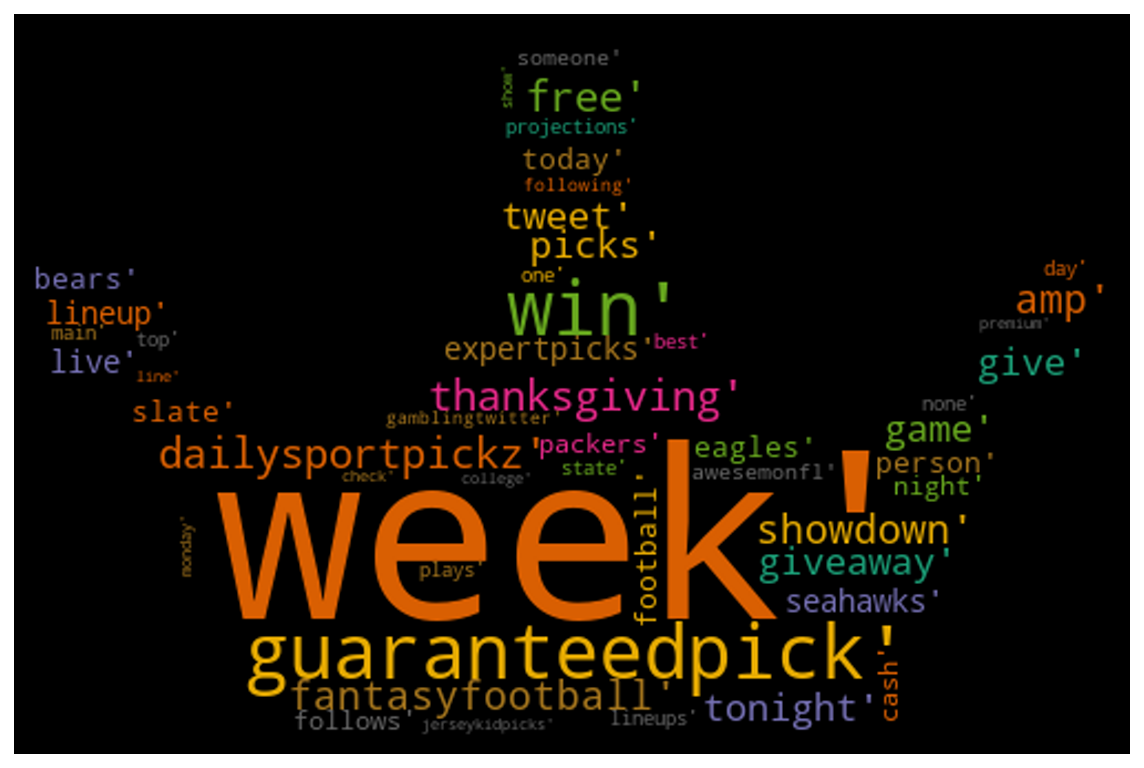

In [784]:
from PIL import Image

dk_wc_words = [word for word in all_words if word not in add_stop_words]
dk_wc_words_counts = Counter(dk_wc_words).most_common(50)

dk_mask = np.array(Image.open('crown.jpg'))

wc = WordCloud(background_color="black", colormap="Dark2",
               max_font_size=150, random_state=42, mask=dk_mask).generate("".join(str(dk_wc_words_counts)))

plt.axis('off')
plt.imshow(wc, interpolation="spline16")
plt.show

### FanDuel

In [785]:
fd_cleaned_tweets = fd_clean.text
fd_all_words = "".join(fd_cleaned_tweets).split()
fd_add_stop_words = [word for word, count in Counter(all_words).most_common() if count > 547]
fd_remove = ['xef', 'rts', 'snf', 'mnf', 'dk', 'dfs', 'cbb', 'gt', 'nthe', 'get', 'nwe', 'give', 'xbd']
for word in fd_remove:
    fd_add_stop_words.append(word)
fd_stop_words = text.ENGLISH_STOP_WORDS.union(fd_add_stop_words)

In [786]:
fd_vectorizer = TfidfVectorizer(min_df=3,  max_features=1500, max_df = .7,
            strip_accents='unicode', analyzer='word', ngram_range = (1,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = fd_stop_words)

fd_X = fd_vectorizer.fit_transform(fd_clean.text)
fd_words = fd_vectorizer.get_feature_names()

In [787]:
#Document Term Matrix
fd_tf_df = pd.DataFrame(fd_X.toarray(), columns=fd_words)
fd_tf_df.to_pickle("data/fd_tf_df.pkl")

<function matplotlib.pyplot.show(*args, **kw)>

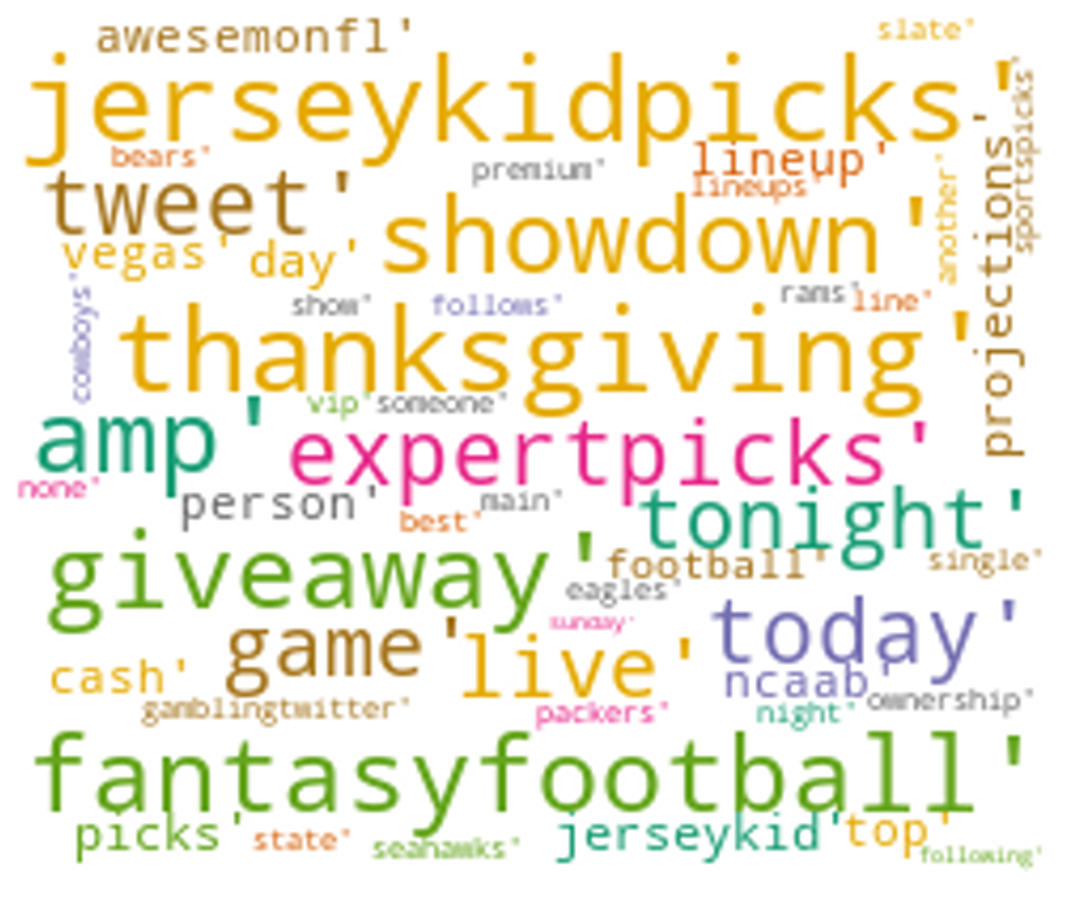

In [788]:
fd_wc_words = [word for word in fd_all_words if word not in fd_add_stop_words]
fd_wc_words_counts = Counter(fd_wc_words).most_common(50)

fd_mask = np.array(Image.open('fanduel.jpg'))

wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42, mask=fd_mask).generate("".join(str(fd_wc_words_counts)))

plt.axis('off')
plt.imshow(wc, interpolation="spline16")
plt.show

In [789]:
pickle.dump(dk_vectorizer, open("data/dk_vectorizer.pkl", "wb"))
pickle.dump(fd_vectorizer, open("data/fd_vectorizer.pkl", "wb"))

### Top Word Comparison

In [790]:
dk_top_words = []
for i in range(len(dk_wc_words_counts)):
    dk_top_words.append(dk_wc_words_counts[i][0])

fd_top_words = []
for i in range(len(fd_wc_words_counts)):
    fd_top_words.append(fd_wc_words_counts[i][0])

In [791]:
dk_difference = list(set(dk_top_words) - set(fd_top_words))
dk_difference

['win',
 'college',
 'give',
 'dailysportpickz',
 'week',
 'free',
 'monday',
 'plays',
 'guaranteedpick',
 'one',
 'check']

In [792]:
fd_difference = list(set(fd_top_words) - set(dk_top_words))
fd_difference

['ownership',
 'cowboys',
 'sportspicks',
 'another',
 'rams',
 'vegas',
 'ncaab',
 'jerseykid',
 'vip',
 'single',
 'sunday']

In [793]:
data_tuples = list(zip(dk_top_words, fd_top_words))
top_words_df = pd.DataFrame(data_tuples, columns = ['DraftKings', 'FanDuel'])
top_words_df

,DraftKings,FanDuel
0,week,jerseykidpicks
1,guaranteedpick,thanksgiving
2,win,fantasyfootball
3,dailysportpickz,amp
4,free,giveaway
5,thanksgiving,showdown
6,fantasyfootball,expertpicks
7,showdown,tweet
8,amp,today
9,giveaway,tonight


In [794]:
difference_tuples = list(zip(dk_difference, fd_difference))
difference_words_df = pd.DataFrame(difference_tuples, columns = ['Only in DraftKings', 'Only in FanDuel'])
difference_words_df

,Only in DraftKings,Only in FanDuel
0,win,ownership
1,college,cowboys
2,give,sportspicks
3,dailysportpickz,another
4,week,rams
5,free,vegas
6,monday,ncaab
7,plays,jerseykid
8,guaranteedpick,vip
9,one,single


# NMF Topic Modeling

In [801]:
dk_clean.head()

,text
0,service college basketball nit us verified members already ver co
1,nfl dfs seahawks eagles nwe hit cash na perfect week gt nfl dfs record ndm informa co
2,awesemogolf live nthe awesemogolf pga dfs strategy show mayakobaclassic jazzrazdfs amp fantasygolfman n draftkings fandue
4,boooom nverified winner day n xbd xef xbd xef salzburg ov xbd xef xbd xef co jqyhhokgcc
5,week waivers faab auction bids cut list defense streamers week reactions kicker ranking co


In [795]:
dk_vocab = np.array(dk_vectorizer.get_feature_names())
fd_vocab = np.array(fd_vectorizer.get_feature_names())

In [796]:
from sklearn.decomposition import NMF

dk_nmf = NMF(n_components=3, max_iter=2000, alpha=0.0)
dk_W = dk_nmf.fit_transform(dk_X)
dk_H = dk_nmf.components_
print('dk_reconstruction error:', dk_nmf.reconstruction_err_)

fd_nmf = NMF(n_components=3, max_iter=2000, alpha=0.0)
fd_W = fd_nmf.fit_transform(fd_X)
fd_H = fd_nmf.components_
print('fd_reconstruction error:', fd_nmf.reconstruction_err_)

dk_reconstruction error: 69.82795894468062
fd_reconstruction error: 63.77332777918854


In [802]:
def label_topics(H, vocabulary):
    labels = []
    for i, row in enumerate(H):
        top_five = np.argsort(row)[::-1][:30]
        print('topic', i)
        print('-->', ' '.join(vocabulary[top_five]))
        label = input('\n' + 'topic guess:')
        labels.append(label)
        print()
    return labels

In [804]:
dk_topic_labels = label_topics(dk_H, dk_vocab)

topic 0
--> win tonight tweet follows follows tonight tweet win dailysportpickz packers bears packers win tonight bears person tweet bears person dailysportpickz packers person tonight seahawks seahawks tweet eagles win ven follows ven dailysportpickz eagles seahawks eagles bears win tonight packers packers tweet dailysportpickz bears venmo follows venmo dailysportpickz giveaway



topic guess: 1



topic 1
--> free giveaway giveaway person person win following free following person dailysportpickz win lineup lineup free premium seahawks eagles win premium premium lineup eagles giveaway showdown dailysportpickz seahawks following ente ente seahawks line eagles line free enter win line following enter fantasyfootball packers bears bears giveaway



topic guess: 1



topic 2
--> guaranteedpick guaranteedpick realbobbasports realbobbasports expertpicks marchmadness guaranteedpick servicesbam servicesbam state guaranteedpick expertpicks expertpicks sportspicks sportspicks realbobbasports expertpicks servicesbam expertpicks state guaranteedpick realbobbasports marchmadness texas servicesbam marchmadness carolina sportspicks mlb mlb marchmadness expertpicks guaranteedpick marchmadness city guaranteedpick thewackyreport thewackyreport st north guaranteedpick tampasports tampasports guaranteedpick thewagermakers



topic guess: 1


<function matplotlib.pyplot.show(*args, **kw)>

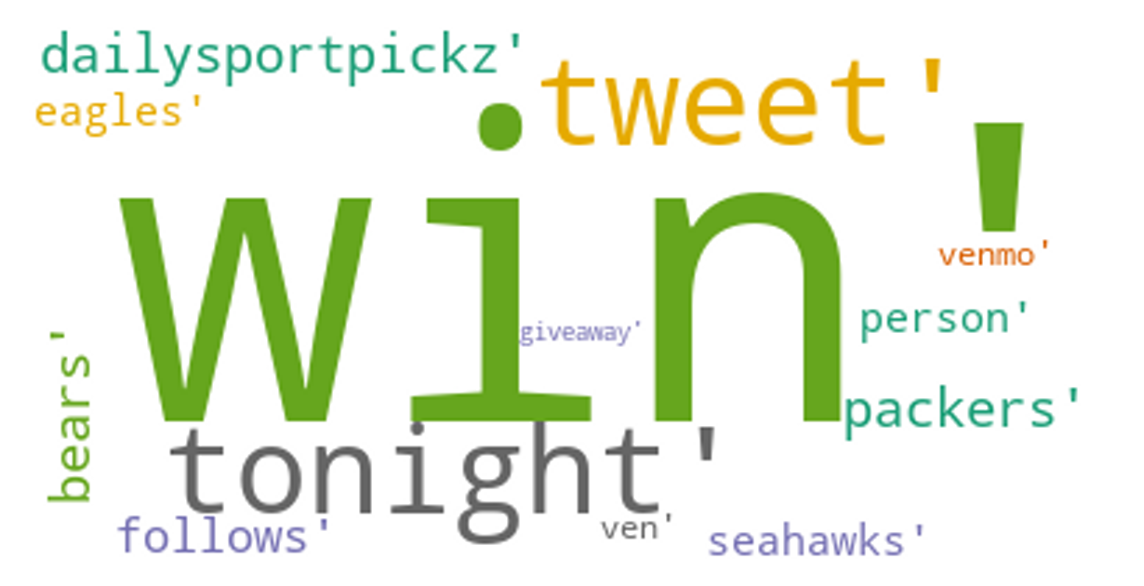

In [809]:
game = 'win tonight tweet follows follows tonight tweet win dailysportpickz packers bears packers win tonight bears person tweet bears person dailysportpickz packers person tonight seahawks seahawks tweet eagles win ven follows ven dailysportpickz eagles seahawks eagles bears win tonight packers packers tweet dailysportpickz bears venmo follows venmo dailysportpickz giveaway' 
game = game.split()



wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=30, mask=None).generate("".join(str(game)))

plt.axis('off')
plt.imshow(wc, interpolation="spline16")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

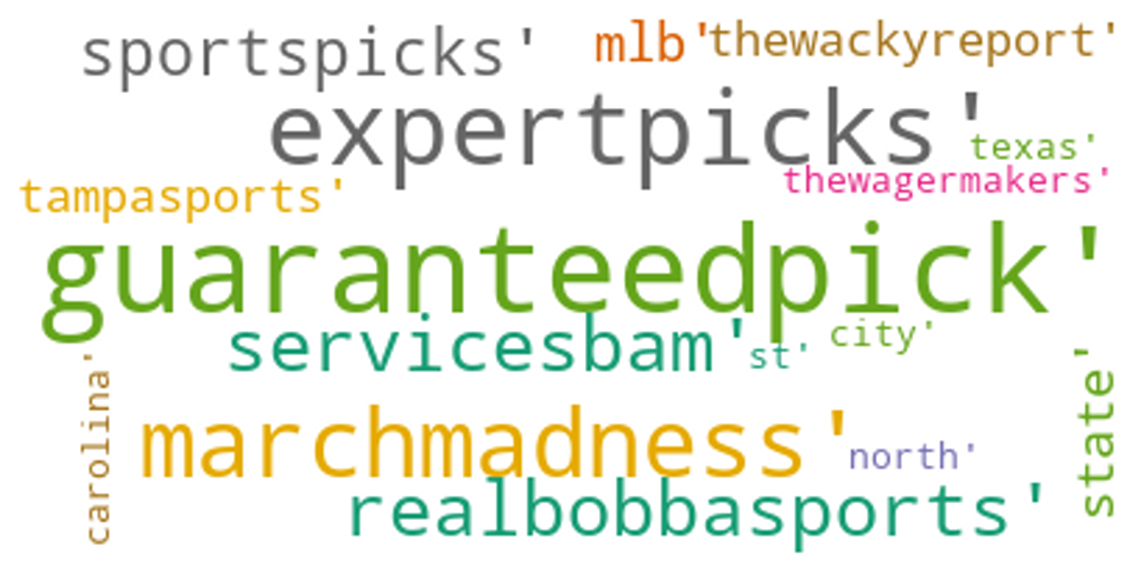

In [810]:
bets = 'guaranteedpick guaranteedpick realbobbasports realbobbasports expertpicks marchmadness guaranteedpick servicesbam servicesbam state guaranteedpick expertpicks expertpicks sportspicks sportspicks realbobbasports expertpicks servicesbam expertpicks state guaranteedpick realbobbasports marchmadness texas servicesbam marchmadness carolina sportspicks mlb mlb marchmadness expertpicks guaranteedpick marchmadness city guaranteedpick thewackyreport thewackyreport st north guaranteedpick tampasports tampasports guaranteedpick thewagermakers'
bets = bets.split()



wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=30, mask=None).generate("".join(str(bets)))

plt.axis('off')
plt.imshow(wc, interpolation="spline16")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

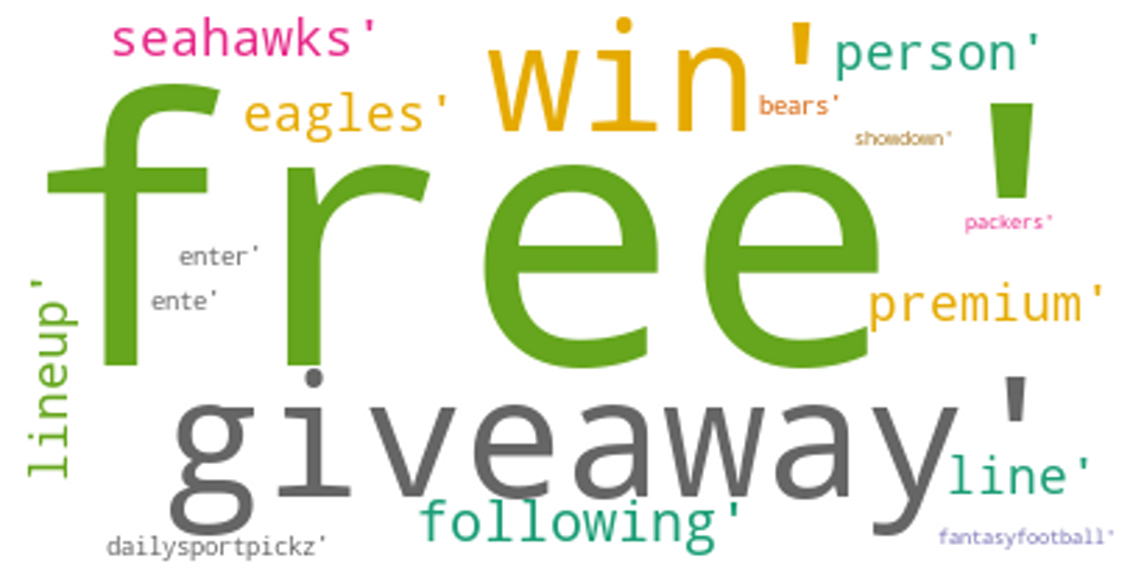

In [813]:
promo = 'free giveaway giveaway person person win following free following person dailysportpickz win lineup lineup free premium seahawks eagles win premium premium lineup eagles giveaway showdown dailysportpickz seahawks following ente ente seahawks line eagles line free enter win line following enter fantasyfootball packers bears bears giveaway'

promo = promo.split()



wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=30, mask=None).generate("".join(str(promo)))

plt.axis('off')
plt.imshow(wc, interpolation="spline16")
plt.show

In [760]:
fd_topic_labels = label_topics(fd_H, fd_vocab)

topic 0
--> tweet follows follows tonight tweet packers bears packers tonight person tweet bears person tonight bears person eagles tonight tonight seahawks seahawks tweet ven



topic guess: Upcoming Game



topic 1
--> fantasyfootball ownership projections game ownership projections projections fantasyfootball single single game showdown single showdown rankings thanksgiving ownership rankings rankings fantasyfootball thanksgiving fantasyfootball



topic guess: Picks and Bets



topic 2
--> giveaway giveaway person following nmust nmust following person thanksgiving lineup showdown cowboys line thanksgiving showdown redskins lineup nmust premium



topic guess: Promotions


## Draktkings Topic Dataframe

In [758]:
dk_W.shape

(5257, 3)

In [759]:
dk_topic = pd.DataFrame(dk_W, columns = dk_topic_labels)
dk_topic['topic_guess'] = dk_topic.idxmax(axis=1)

In [763]:
dk_topic.head(50)

,Upcoming Game,Promotions,Picks and Bets,topic_guess
0,0.000000,0.006167,0.004777,Promotions
1,0.004741,0.041442,0.002216,Promotions
2,0.000000,0.006343,0.002170,Promotions
3,0.000000,0.002479,0.001273,Promotions
4,0.000000,0.003638,0.000240,Promotions
5,0.000000,0.000000,0.115897,Picks and Bets
6,0.000000,0.006718,0.002298,Promotions
7,0.000000,0.006718,0.002298,Promotions
8,0.000000,0.007682,0.002312,Promotions
9,0.000000,0.006718,0.002298,Promotions


In [761]:
dk_counter = dict(Counter(dk_topic.topic_guess))
for k, v, in dk_counter.items():
    dk_counter[k] = str(round((v/5257)*100))+'%'
dk_counter

{'Promotions': '73%', 'Picks and Bets': '18%', 'Upcoming Game': '8%'}

In [762]:
game_indexes = dk_topic[dk_topic.topic_guess == "Upcoming Game"].index
game = dk.loc[dk.index.isin(game_indexes)]
pd.set_option("display.max_colwidth", None)
game.head(60)

,created,text,username,location,follower count,friend count,retweet,source
19,12/01/2020,"b""\xf0\x9f\x8f\x80Brian's Top CBB Targets 12/1\xf0\x9f\x8f\x80\n#DFS #CBB #draftkings #fanduel\nhttps://t.co/SLIm1FmuIe https://t.co/TzjYengxrx""",DFS_Karma,"Cleveland, OH",18730,48,0,Hootsuite Inc.
119,12/01/2020,b'https://t.co/7wyuE2Dqgg 12/01 (625) SOUTH DAKOTA UNIVERSITY vs. (626) Nebraska #guaranteedpick REALBOBBASPORTS\xe2\x80\xa6 https://t.co/rASMyjQU4s',SportsWatch1,"Las Vegas, NV",12309,22797,1,SWM Automated Tweets For Members
177,12/01/2020,"b'Re-tweet from NFL Throwback \xf0\x9f\x92\xac,""....... 18 years ago today, MichaelVick walked it off in OT. (Dec. 1, 2002)\xe2\x80\xa6 https://t.co/9b5oZqh2gG'",DFSPrimeLineups,Winners Lane,6163,1134,0,Zapier.com
181,12/01/2020,b'\xe2\x80\x98Horse racing Betting Tips! Here is a great plan! Listen please!\xe2\x80\x99 on #SoundCloud #np https://t.co/O9EGnCX4KF #CT\xe2\x80\xa6 https://t.co/4WUhkRqWXR',coollikeme,"Connecticut, USA",6148,6742,0,Twitter Web App
221,12/01/2020,b'Study A Pro: @AwesemoDFS | CSGO DraftKings Lineups\n#draftkings #fanduel #esports #dfs #CSGO\nhttps://t.co/2YqstY6O0h',AwesemoEsports,"Chicago, IL",1237,227,0,Sprout Social
227,12/01/2020,b'RT @surefire_bets: What is your favorite sportsbook in the U.S.?\n\n#investing #sports #sportsbetting #fanduel #draftkings #casino',news24x75,NaN,301,10,1,NaN
228,12/01/2020,"b'RT @GirlNextDoorBet: Made 4k today on CAAS, ZM and CHWY.. while the market tanked.. Betting the UNDER on MNF.. and UCF in NCAAB .. trying f\xe2\x80\xa6'",EduardoLouzada8,"Phoenix, AZ",89,446,16,Twitter for iPhone
233,12/01/2020,"b'RT @GirlNextDoorBet: Made 4k today on CAAS, ZM and CHWY.. while the market tanked.. Betting the UNDER on MNF.. and UCF in NCAAB .. trying f\xe2\x80\xa6'",Mrietherman1,NaN,538,968,16,Twitter for Android
239,12/01/2020,b'RT @AnalyticsShark: I\xe2\x80\x99ll take the wild play at the end of game if it means Eagles +6.5 going to cash and my wentz over 1.5 TDs going to cas\xe2\x80\xa6',ebrwn_7,NaN,1052,664,2,Twitter for iPhone
240,12/01/2020,b'College Basketball is too easy for the @rotoplug team. Nice hits @jimxsolo @GreezyKeezy y\xe2\x80\x99all really been doing it\xe2\x80\xa6 https://t.co/o285U6xsxP',rotoplug,NaN,7,15,1,Twitter for iPhone


In [775]:
promotions_indexes = dk_topic[dk_topic.topic_guess == "Promotions"].index
promotions = dk.loc[df.index.isin(promotions_indexes)]
pd.set_option("display.max_colwidth", None)
# unique = promotions[promotions.retweet < 100]
unique = promotions.retweet.unique()
Counter(unique).most_common(10)

[(0, 1),
 (1, 1),
 (2, 1),
 (8, 1),
 (4, 1),
 (11, 1),
 (3, 1),
 (16, 1),
 (6, 1),
 (36, 1)]

In [710]:
picks_indexes = dk_topic[dk_topic.topic_guess == "Picks and Bets"].index
picks = dk.loc[dk.index.isin(picks_indexes)]
pd.set_option("display.max_colwidth", None)
picks.head(50)

,created,text,username,location,follower count,friend count,retweet,source
5,2020-12-01 19:38:51,b'\xf0\x9f\x92\xb0 Week 13 Waivers -- FAAB Auction Bids -- The Cut List -- Defense Streamers -- Week 12 Reactions -- Kicker Ranking\xe2\x80\xa6 https://t.co/0pOnZsTunu',RotoBaller,Listen in live on SiriusXM 🎙,20982,2743,0,Mailchimp
28,2020-12-01 18:48:50,b'Im feeling good I feel a big hit today \xf0\x9f\x8f\x80\xf0\x9f\x8f\x80\xf0\x9f\x8f\x80\xf0\x9f\x8f\x80 \xf0\x9f\x8f\x80 \xf0\x9f\x92\xb0\xf0\x9f\x92\xb0\xf0\x9f\x92\xb0 #fanduel #college #draftkings',FanDuelWizard,NaN,2704,4979,0,Twitter for iPhone
30,2020-12-01 18:46:32,b'RT @DFS_Punisher04: @dfs_ace Griff another steady month of #DFS low stakes across #DraftKings and #FanDuel. #FreakMode Hobbytown! https://t\xe2\x80\xa6',dfs_ace,dfspunisher04@gmail.com,645,108,1,Twitter for iPhone
37,2020-12-01 18:25:22,"b'Since I made a #Steelers-#Ravens #DraftKings Showdown lineup, the game will probably get moved or changed again som\xe2\x80\xa6 https://t.co/R1Y2R2H9qO'",BillyHeyen,"Rochester, NY",1595,2271,0,Twitter Web App
38,2020-12-01 18:24:31,b'After a weekend of winning &amp; another SD win! #DraftKings #dfs #fanduel #nfl https://t.co/27X2WRGbbQ',DfsEggheads,NaN,639,418,0,Twitter for iPhone
40,2020-12-01 18:19:12,b'@dfs_ace Griff another steady month of #DFS low stakes across #DraftKings and #FanDuel. #FreakMode Hobbytown! https://t.co/a72hc0fdef',DFS_Punisher04,"Chicago, IL",1238,1249,1,Twitter for iPhone
42,2020-12-01 18:16:57,b'https://t.co/VpbTMdpCRh 12/01 (631) North Carolina vs. (632) Stanford #guaranteedpick #marchmadness #expertpicks\xe2\x80\xa6 https://t.co/EfpnHzevWh',SportsWatch1,"Las Vegas, NV",12309,22797,1,SWM Automated Tweets For Members
48,2020-12-01 18:00:30,b'Here is an easy tip to improve your lineups. Stay away from these guys on larger slates. #PlugTalk #DFS #CBB #NBA\xe2\x80\xa6 https://t.co/9FyOTHKwLR',rotoplug,NaN,7,15,0,Twitter for iPhone
53,2020-12-01 17:48:40,"b""RT @DailyFantasyCPA: December 1 is the start of what's known as the witching month... where DFS losses become wins and where wins stay wins\xe2\x80\xa6""",WhoTF_isJay,"Columbus, GA",100,695,2,Twitter for iPhone
56,2020-12-01 17:31:17,"b""December 1 is the start of what's known as the witching month... where DFS losses become wins and where wins stay wins\n\n#Fanduel #Draftkings""",DailyFantasyCPA,Washington DC,2696,586,2,Twitter Web App


## Fanduels Topic DataFrame

In [614]:
fd_W.shape

(4321, 3)

In [615]:
fd_topic = pd.DataFrame(fd_W, columns = fd_topic_labels)
fd_topic['topic_guess'] = fd_topic.idxmax(axis=1)

In [673]:
fd_counter = dict(Counter(fd_topic.topic_guess))
for k, v, in fd_counter.items():
    fd_counter[k] = str(round((v/4321)*100))+'%'
    
fd_counter


{'Thirsty for Followers': '69%',
 'Picks and Bets': '25%',
 "Tonight's Game": '7%'}

In [618]:
fd_game_indexes = fd_topic[fd_topic.topic_guess == "Tonight's Game"].index
fd_game = fd.loc[fd.index.isin(fd_game_indexes)]
pd.set_option("display.max_colwidth", None)
fd_game.head(10)

,created,text,username,location,follower count,friend count,retweet,source
40,2020-12-01 17:35:05,"b""RT @VegasSyndicate: BOOOM\xf0\x9f\x92\xa5\xf0\x9f\x92\xa5\xf0\x9f\x92\xa5\xf0\x9f\x92\xa5TD KENT STATE !\n\nWE HAVE 59 POINTS AT HALF TIME... OUR VIP'S BET OVER 67... LETS GET THIS WINNER IN...\n\n#GAMBL\xe2\x80\xa6""",anumjunaid15,NaN,27,1828,21,Twitter Web App
46,2020-12-01 17:29:11,b'THIS HAS HAPPENED TO EVERY SPORTS BETTOR! SEND US YOUR BAD BEATS! #parlay #badbeats #knockout #draftkings #fanduel\xe2\x80\xa6 https://t.co/QELyTTQEcg',SPORT_SHARKS,NaN,6,35,0,Instagram
48,2020-12-01 17:26:59,b'YS SquaD cooking #fanduel https://t.co/jyGwPKPo5s',Yesi_SquaD,NaN,1129,206,0,Twitter for iPhone
124,2020-12-01 15:20:03,b'RT @DFSPrimeLineups: \xf0\x9f\x94\xa5Join #FREE \xe2\x9e\xa1\xef\xb8\x8f https://t.co/dLBNGuv5It\xf0\x9f\x94\xa5 as another #win was just posted for Team Prime! The #best #DailyFantasySports\xe2\x80\xa6',DFSPrimeLineups,Winners Lane,6163,1134,0,Twitter for iPhone
126,2020-12-01 15:02:05,"b'Check out our SFTB NFL FanDuel Picks for Week 13, 2020. #NFL #FanDuel #DFS &gt;&gt;&gt;&gt;&gt;&gt;&gt; https://t.co/6KhrD3HD85'",sportsftb,"Brooklyn, NY",503,937,0,Sports from the Basement
141,2020-12-01 13:45:04,b'Study A Pro: @AwesemoDFS | CSGO DraftKings Lineups\n#draftkings #fanduel #esports #dfs #CSGO\nhttps://t.co/hpftUHu4RD',Awesemo_Com,"Chicago, IL",25663,592,0,Sprout Social
148,2020-12-01 13:20:49,b'RT @BRIGGS_USA: Join the movement tonight with\n\nhttps://t.co/xcXMNVQZNY \n\n#ncaabasketball #cbb #nflfootball #WagerTalkToday #FanDuel #TheE\xe2\x80\xa6',WallStreetWill2,"NEW YORK, USA",116,193,9,Twitter Web App
223,2020-12-01 07:21:31,b'The toughest part of DFS is staying mentally strong during long stretches of struggle. I\xe2\x80\x99m grinding through it but\xe2\x80\xa6 https://t.co/tHYwm8EorA',JoshDFS1,NaN,32,21,0,Twitter for iPhone
227,2020-12-01 06:15:00,b'The @AwesemoEsports CSGO DFS Ownership Projections\n#draftkings #fanduel #esports #dfs #CSGO\nhttps://t.co/PDkkGUymqr',AwesemoEsports,"Chicago, IL",1237,227,0,Sprout Social
249,2020-12-01 04:44:37,b'BOOOOM\xf0\x9f\xa5\xb3\xf0\x9f\x92\xa5\n\nVERIFIED WINNER #6 ON THE DAY!\n\n \xf0\x9f\x91\x91\xf0\x9f\x8f\xa7\xf0\x9f\x91\x91\xf0\x9f\x8f\xa7\xf0\x9f\x91\x91\xf0\x9f\x8f\xa7\xf0\x9f\x91\x91\xf0\x9f\x8f\xa7\xf0\x9f\x91\x91\xf0\x9f\x8f\xa7\xf0\x9f\x91\x91\n\xf0\x9f\x92\x8e\xf0\x9f\x8f\x80\xf0\x9f\x92\x8e\xf0\x9f\x8f\x80TEXAS SOUTHERN +10.5\xf0\x9f\x92\x8e\xf0\x9f\x8f\x80\xf0\x9f\x92\x8e\xf0\x9f\x8f\x80\n \xf0\x9f\x91\x91\xf0\x9f\x8f\x80\xf0\x9f\x8f\xa7\xf0\x9f\x91\x91\xf0\x9f\x8f\xa7\xf0\x9f\x8f\x80\xf0\x9f\x91\x91\xf0\x9f\x8f\xa7\xe2\x80\xa6 https://t.co/gsz8OEguj6',VegasSyndicate,"Henderson, Nevada",10320,3406,0,Twitter Web App


In [620]:
fd_thirsty_indexes = fd_topic[fd_topic.topic_guess == "Thirsty for Followers"].index
fd_thirsty = fd.loc[fd.index.isin(fd_thirsty_indexes)]
pd.set_option("display.max_colwidth", None)
fd_thirsty.tail(40)

,created,text,username,location,follower count,friend count,retweet,source
4272,2020-11-26 06:10:00,b'NFL Top Stacks https://t.co/8x6pTtPrSo #Thanksgiving #FantasyFootball #FanDuel #DraftKings',Awesemo_Com,"Chicago, IL",25663,592,0,Sprout Social
4275,2020-11-26 05:55:00,b'NFL Showdown Single Game Ranks https://t.co/EIDP1xXwPO #Thanksgiving #FantasyFootball #FanDuel #DraftKings',Awesemo_Com,"Chicago, IL",25663,592,0,Sprout Social
4276,2020-11-26 05:48:00,b'NFL Projections https://t.co/SrrhmLJaNJ #Thanksgiving #FantasyFootball #FanDuel #DraftKings',AwesemoNFL,"Chicago, IL",8812,191,0,Sprout Social
4277,2020-11-26 05:44:16,b'You hit with us?! \n\n#NCAAB #espn #fanduel #barstool #bettingtips #bettingpicks #parlayking #GeorgiaSt #CBB #loyola\xe2\x80\xa6 https://t.co/QKeu24K3L7',return_big,Bandsville,73,569,0,Twitter for iPhone
4278,2020-11-26 05:40:00,b'NFL Ownership Projections DraftKings https://t.co/GYfZGlBPTD #Thanksgiving #FantasyFootball #FanDuel #DraftKings',Awesemo_Com,"Chicago, IL",25663,592,0,Sprout Social
4279,2020-11-26 05:39:35,b'\xf0\x9f\x94\xa5\xf0\x9f\x94\xa5\xf0\x9f\x94\xa5 VERIFIED VIP CASH \xf0\x9f\x94\xa5\xf0\x9f\x94\xa5\xf0\x9f\x94\xa5\n \xf0\x9f\x92\x8e\xf0\x9f\x8f\x802ND INCOME U DESERVE \xf0\x9f\x8f\x80\xf0\x9f\x92\x8e\n \xf0\x9f\x92\xb0 \xf0\x9f\x8f\xa7 ENJOY YOUR LIFE \xf0\x9f\x8f\xa7 \xf0\x9f\x91\x91\n\xf0\x9f\x8f\xa7\xf0\x9f\x8f\x80\xf0\x9f\x8f\xa7\xf0\x9f\x8f\x80\xf0\x9f\x8f\xa7\xf0\x9f\x8f\x80\xf0\x9f\x8f\xa7\xf0\x9f\x8f\x80\xf0\x9f\x8f\xa7\xf0\x9f\x8f\x80\xf0\x9f\x8f\xa7\xf0\x9f\x8f\x80\n \xf0\x9f\x94\xa5\xf0\x9f\x92\x8eSAN DIEGO ST\xe2\x80\xa6 https://t.co/SXuW47uCU5',VegasSyndicate,"Henderson, Nevada",10320,3407,0,Twitter Web App
4280,2020-11-26 05:37:50,b'\xf0\x9f\x94\xa5\xf0\x9f\x94\xa5\xf0\x9f\x94\xa5 VERIFIED VIP CASH \xf0\x9f\x94\xa5\xf0\x9f\x94\xa5\xf0\x9f\x94\xa5\n \xf0\x9f\x92\x8e\xf0\x9f\x8f\x802ND INCOME U DESERVE \xf0\x9f\x8f\x80\xf0\x9f\x92\x8e\n \xf0\x9f\x92\xb0 \xf0\x9f\x8f\xa7 ENJOY YOUR LIFE \xf0\x9f\x8f\xa7 \xf0\x9f\x91\x91\n\xf0\x9f\x8f\xa7\xf0\x9f\x8f\x80\xf0\x9f\x8f\xa7\xf0\x9f\x8f\x80\xf0\x9f\x8f\xa7\xf0\x9f\x8f\x80\xf0\x9f\x8f\xa7\xf0\x9f\x8f\x80\xf0\x9f\x8f\xa7\xf0\x9f\x8f\x80\xf0\x9f\x8f\xa7\xf0\x9f\x8f\x80\xe2\x80\xa6 https://t.co/DnIxUwAtAK',VegasSyndicate,"Henderson, Nevada",10320,3407,0,Twitter Web App
4281,2020-11-26 05:33:48,b'@JerseyKidPicks @charlesdovefit @Willy92wins @WallStreetWill2 @ahardy316 All new members you are all gonna love Jer\xe2\x80\xa6 https://t.co/lEpkeH5Vpp',Fingrz692,United States,1824,2898,5,Twitter for Android
4282,2020-11-26 05:33:00,b'NFL Big Board https://t.co/9JaAxJ15tr #Thanksgiving #FantasyFootball #FanDuel #DraftKings',AwesemoNFL,"Chicago, IL",8812,191,0,Sprout Social
4283,2020-11-26 05:32:11,b'RT @Money_LineDFS: FULL BELLY\xe2\x80\x99S AND BANK ACCOUNTS\n\n\xf0\x9f\xa6\x83Your Thanksgiving #DFS Special\xf0\x9f\xa6\x83\n#Thanksgiving #DraftKings #FantasyFootball #FanDuel #DF\xe2\x80\xa6',EthanTabor5,NaN,569,290,3,Twitter for iPhone


In [562]:
fd_picks_indexes = fd_topic[df_topic.topic_guess == "Projections and Picks"].index
fd_picks = fd.loc[fd.index.isin(fd_picks_indexes)]
pd.set_option("display.max_colwidth", None)
fd_picks.tail(20)

,created,text,username,location,follower count,friend count,retweet,source
4958,2020-11-26 21:08:35,"b""25 MINUTES TILL THE #WASvsDAL GAME...\n\nWE HAVE 5 MORE WINNERS TODAY ON THE CARD\n\nSWEEP COMING \n\nLET'S RUN ANOTHER S\xe2\x80\xa6 https://t.co/JivssdpYMw""",VegasSyndicate,"Henderson, Nevada",10320,3406,0,Twitter Web App
5015,2020-11-26 19:35:03,b'\xf0\x9f\x9a\xa8 \xf0\x9f\xa5\x8a FREE TODAY \xf0\x9f\xa5\x8a \xf0\x9f\x9a\xa8 \n\nThe @AwesemoMMADFS Fighter Projections for #UFCFightNight\n\nhttps://t.co/Ml5Tq61HAS\n\n#ufc\xe2\x80\xa6 https://t.co/i6UvYjoGw4',AwesemoMMADFS,"Chicago, Illinois",1438,207,0,Sprout Social
5020,2020-11-26 19:30:08,b'NFL Top Showdown and Single Game Plays https://t.co/zmsm9nccKp #FantasyFootball #DFS #FanDuel #DraftKings #WASvsDAL',Awesemo_Com,"Chicago, IL",25663,592,0,Sprout Social
5021,2020-11-26 19:30:07,b'Learn How to Play MMA DFS straight from @AwesemoDFS right here #UFC #FanDuel #DraftKings #MMA #DFS https://t.co/VRf3hh9BsR',AwesemoMMADFS,"Chicago, Illinois",1438,207,0,Sprout Social
5028,2020-11-26 19:15:11,b'NFL Showdown Single Game Projections https://t.co/yfz248pifv #FantasyFootball #DFS #FanDuel #DraftKings #WASvsDAL',AwesemoNFL,"Chicago, IL",8812,191,0,Sprout Social
5029,2020-11-26 19:11:02,b'HAPPY THANKSGIVING TO ALL...\n\nILLINOIS WINS BY 59....\xf0\x9f\x98\x86\xf0\x9f\xa5\xb3\xf0\x9f\x8e\x89\xe2\x9b\xbd\xef\xb8\x8f\xf0\x9f\x94\xa5\n\n#GamblingTwitter #FANDUEL #DRAFTKINGS #BTC https://t.co/p6lCgJwfFl',VegasSyndicate,"Henderson, Nevada",10320,3406,1,Twitter Web App
5030,2020-11-26 19:10:07,b'NFL Showdown Single Game Ranks https://t.co/EIDP1xXwPO #FantasyFootball #DFS #FanDuel #DraftKings #WASvsDAL',Awesemo_Com,"Chicago, IL",25663,592,0,Sprout Social
5032,2020-11-26 19:04:43,b'RT @TheGambleGuy_GG: Which one of my #DFS guys had AP in the lineup today? #TeamPicksCity has everyone covered! If there\xe2\x80\x99s a dollar being w\xe2\x80\xa6',PicksCity,NaN,5929,453,2,Twitter for iPhone
5033,2020-11-26 19:02:11,"b""RT @DFSArmy: Don't miss out on our Black Friday Sale!\n\n- 50% off 1st Month of VIP\n- 20% off after that\n- New Subscribers Only\n- Expires Sun\xe2\x80\xa6""",Internet_Eyes,UK,23,18,3,NaN
5107,2020-11-26 17:10:31,b'https://t.co/SkiMSX11vO 11/26 (123) WASHINGTON (NFL) vs. (124) COWBOYS (DAL) #guaranteedpick #expertpicks\xe2\x80\xa6 https://t.co/VELMq4Lthb',SportsWatch1,"Las Vegas, NV",12309,22797,0,SWM Automated Tweets For Members


/Users/LMC/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 50 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


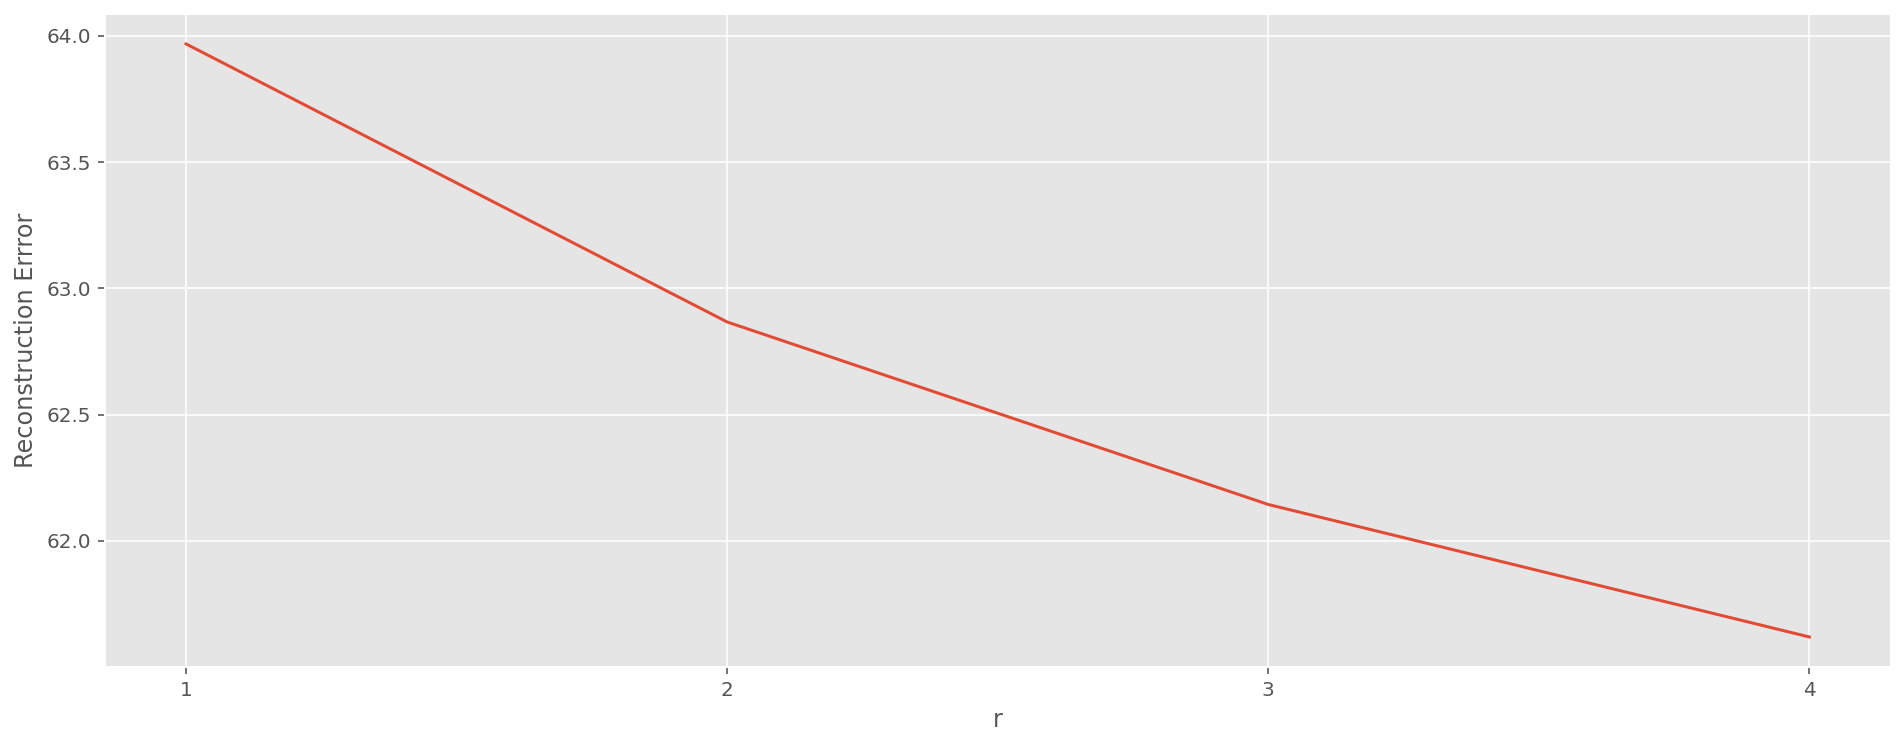

In [563]:
def fit_nmf(r):
    nmf = NMF(n_components=r, max_iter=50, alpha=0.0)
    nmf.fit(X)
    W = nmf.transform(dk_X)
    H = nmf.components_
    return nmf.reconstruction_err_

error = [fit_nmf(i) for i in range(1,5)]
plt.plot(range(1,5), error)
plt.xticks(range(1, 5))
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')
plt.show()

## Presentation Images (stocks and background0

In [636]:
stock = pd.read_csv('DKNG.csv')
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-24,20.493999,20.750000,17.600000,19.350000,19.350000,11444900
1,2020-04-27,22.360001,22.500000,19.500000,19.520000,19.520000,9594200
2,2020-04-28,19.860001,19.900000,18.000000,18.240000,18.240000,5725700
3,2020-04-29,18.350000,19.799999,18.350000,19.400000,19.400000,3649400
4,2020-04-30,19.500000,19.850000,18.879999,19.459999,19.459999,3974800


In [637]:
stock.shape


(155, 7)

In [638]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       155 non-null    object 
 1   Open       155 non-null    float64
 2   High       155 non-null    float64
 3   Low        155 non-null    float64
 4   Close      155 non-null    float64
 5   Adj Close  155 non-null    float64
 6   Volume     155 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 8.6+ KB


In [639]:
stock['Date'] = stock['Date'].apply(pd.to_datetime)
stock.set_index('Date', inplace = True)
stock.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-25,47.790001,51.080002,47.770000,50.230000,50.230000,23223100
2020-11-27,51.820000,52.980000,50.707001,52.750000,52.750000,15833100
2020-11-30,53.500000,53.720001,49.080002,52.360001,52.360001,24757400
2020-12-01,52.355999,52.660000,49.939999,50.779999,50.779999,15613500
2020-12-02,49.360001,51.490002,48.419998,51.099998,51.099998,11925100


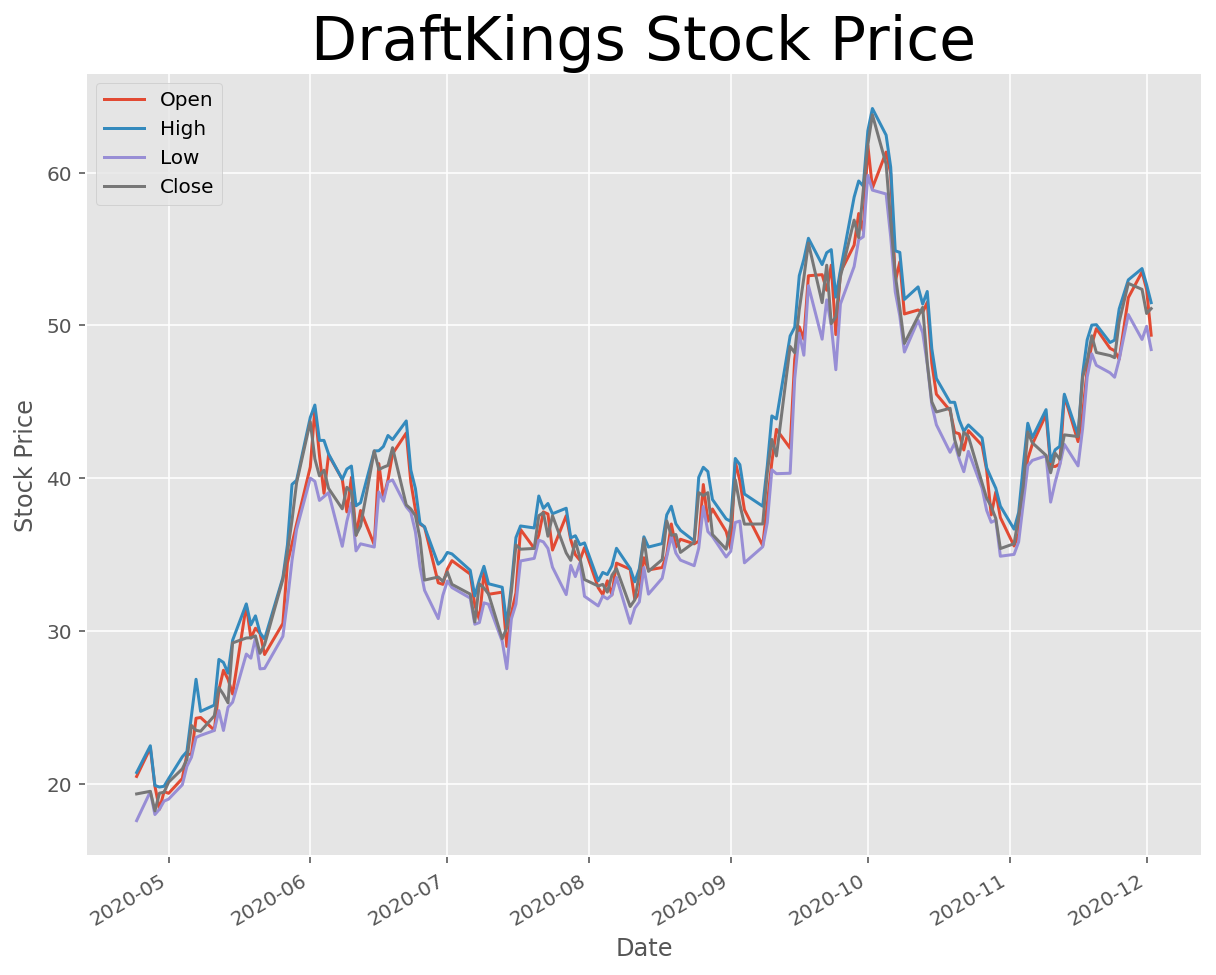

In [644]:
plt.rcParams['figure.figsize'] = (10,8)
stock['Open'].plot(grid=True, label ='Open')
stock['High'].plot(grid=True, label = 'High')
stock['Low'].plot(grid=True, label = 'Low')
stock['Close'].plot(grid=True, label = 'Close')
plt.ylabel('Stock Price')
plt.legend(loc='upper left')
plt.title('DraftKings Stock Price', fontsize=30)
plt.savefig('DK Stock Price')

<function matplotlib.pyplot.show(*args, **kw)>

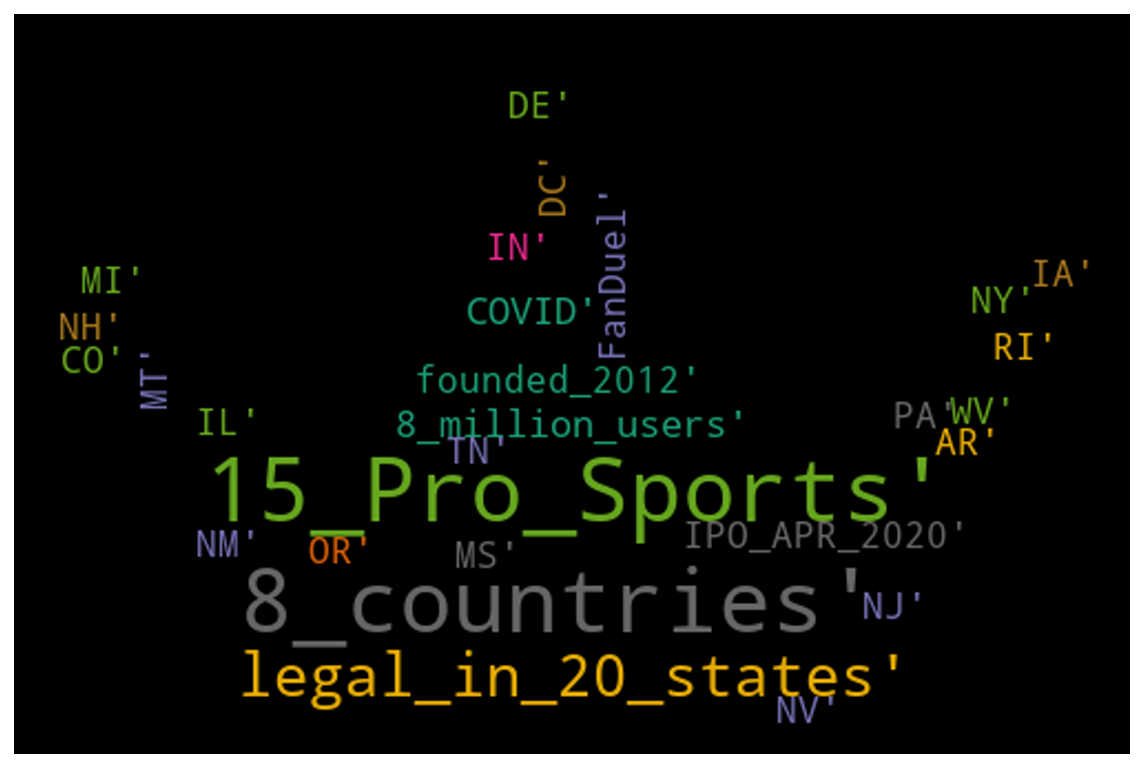

In [663]:
from PIL import Image

dk_wc_words = [word for word in all_words if word not in add_stop_words]
dk_wc_words_counts = Counter(dk_wc_words).most_common(50)
words = ['15_Pro_Sports', '8_countries', 'legal_in_20_states','8_million_users', 
         'COVID', 'IPO_APR_2020', 'FanDuel','founded_2012',
         'NH', 'RI', 'DE', 'DC', 'NY', 'NJ','PA', 'MI', 'WV', 
        'IL', 'IN', 'TN', 'MS', 'IA', 'AR', 'MT', 'CO', 'NM', 'NV', 'OR']

dk_mask = np.array(Image.open('crown.jpg'))

wc = WordCloud(background_color="black", colormap="Dark2",
               max_font_size=40, random_state=30, mask=dk_mask).generate("".join(str(words)))

plt.axis('off')
plt.imshow(wc, interpolation="spline16")
plt.savefig('Background_wordcloud.png')
plt.show